<a href="https://colab.research.google.com/github/JunXinVan/Dynamic-workload-allocation-mechanism-for-content-moderatorss/blob/main/%E2%80%9CSteffen_Bollman_Deep_learning_QSM_tutorial_OHBM_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC111.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Intro


Disclaimer: This code is not the DeepQSM source code used in the publications and was newly written for the OHBM educational course.

Intro to Jupyter/Colab notebooks & Keras from last year's course:
https://colab.research.google.com/github/akeshavan/IntroDL/blob/master/IntroToKeras.ipynb



# QSM data from the 2018 reconstruction challenge


## Download data to google drive

In [5]:
from google.colab import drive
import os

drive.mount('/content/gdrive')
!mkdir -p /content/gdrive/My\ Drive/dlqsm
os.chdir("/content/gdrive/My Drive/dlqsm")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
# uncomment to download the data again
!wget -nc http://www.neuroimaging.at/media/qsm/20170327_qsm2016_recon_challenge.zip
!unzip -uo 20170327_qsm2016_recon_challenge.zip

File ‘20170327_qsm2016_recon_challenge.zip’ already there; not retrieving.

Archive:  20170327_qsm2016_recon_challenge.zip


## View QSM data

In [7]:
import matplotlib.pyplot as plt

def view_slices_3d(image_3d, slice_nbr, vmin, vmax, title=''):
  print('Matrix size: {}'.format(image_3d.shape))
  fig = plt.figure(figsize=(6, 3))
  plt.suptitle(title, fontsize=10)

  plt.subplot(131)
  plt.imshow(np.take(image_3d, slice_nbr, 2), vmin=vmin, vmax=vmax, cmap='gray')
  plt.title('Axial');

  plt.subplot(132)
  image_rot = ndimage.rotate(np.take(image_3d, slice_nbr, 1),90)
  plt.imshow(image_rot, vmin=vmin, vmax=vmax, cmap='gray')
  plt.title('Coronal');

  plt.subplot(133)
  image_rot = ndimage.rotate(np.take(image_3d, slice_nbr, 0),90)
  plt.imshow(image_rot, vmin=vmin, vmax=vmax, cmap='gray')
  plt.title('Sagittal');
  cbar=plt.colorbar()

Brain FW Full shape: (160, 160, 160)
Matrix size: (160, 160, 160)
Matrix size: (160, 160, 160)


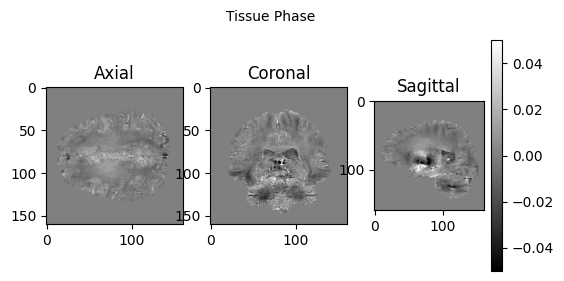

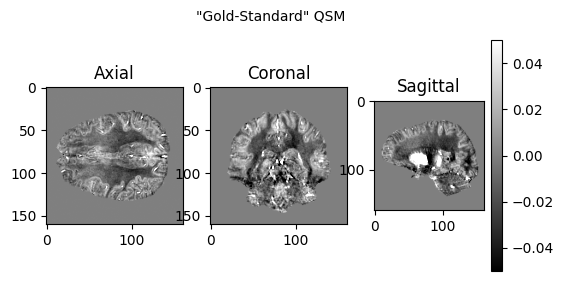

In [8]:
import nibabel as nib
import numpy as np
from matplotlib import transforms
from scipy import ndimage

# load data
brain_fw_full = nib.load('20170327_qsm2016_recon_challenge/data/phs_tissue.nii.gz').get_fdata()
brain_gt_full = nib.load('20170327_qsm2016_recon_challenge/data/chi_33.nii.gz').get_fdata()
print("Brain FW Full shape:", brain_fw_full.shape)
view_slices_3d(brain_fw_full, slice_nbr=100, vmin=-0.05, vmax=0.05, title='Tissue Phase')
view_slices_3d(brain_gt_full, slice_nbr=100, vmin=-0.05, vmax=0.05, title='"Gold-Standard" QSM')



# Simulate susceptibility sources and tissue phase



## Simulate susceptibility distribution

In [9]:
import numpy as np

def simulate_susceptibility_sources(simulation_dim = 160,
                                    rectangles_total = 100,
                                    spheres_total = 80,
                                    sus_std = 1,     # standard deviation of susceptibility values
                                    shape_size_min_factor = 0.01,
                                    shape_size_max_factor = 0.5):

  temp_sources = np.zeros((simulation_dim, simulation_dim, simulation_dim))


  for shapes in range(rectangles_total):
      shrink_factor = 1/((shapes/rectangles_total+1))
      shape_size_min = np.floor(simulation_dim * shrink_factor * shape_size_min_factor)
      shape_size_max = np.floor(simulation_dim * shrink_factor * shape_size_max_factor)

      print(shape_size_min)
      print(shape_size_max)
      print('---------------')

      susceptibility_value = np.random.normal(loc=0.0, scale=sus_std)
      random_sizex = np.random.randint(low=shape_size_min, high=shape_size_max)
      random_sizey = np.random.randint(low=shape_size_min, high=shape_size_max)
      random_sizez = np.random.randint(low=shape_size_min, high=shape_size_max)
      x_pos = np.random.randint(simulation_dim)
      y_pos = np.random.randint(simulation_dim)
      z_pos = np.random.randint(simulation_dim)

      x_pos_max = x_pos + random_sizex
      if x_pos_max >= simulation_dim:
          x_pos_max = simulation_dim

      y_pos_max = y_pos + random_sizey
      if y_pos_max >= simulation_dim:
          y_pos_max = simulation_dim

      z_pos_max = z_pos + random_sizez
      if z_pos_max >= simulation_dim:
          z_pos_max = simulation_dim

      temp_sources[x_pos:x_pos_max, y_pos:y_pos_max, z_pos:z_pos_max] = susceptibility_value

  return temp_sources
  #模拟磁化源
  #此处仅仅使用了矩形，没有加入球形，想复杂化训练数据可以（1）加大模拟空间大小 （2）增加生成的形状数量  （3）增大磁化率标准差 （4）生成不同大小和形状的磁化率源

3.0
160.0
---------------
3.0
159.0
---------------
3.0
159.0
---------------
3.0
159.0
---------------
3.0
159.0
---------------
3.0
159.0
---------------
3.0
158.0
---------------
3.0
158.0
---------------
3.0
158.0
---------------
3.0
158.0
---------------
3.0
158.0
---------------
3.0
157.0
---------------
3.0
157.0
---------------
3.0
157.0
---------------
3.0
157.0
---------------
3.0
157.0
---------------
3.0
156.0
---------------
3.0
156.0
---------------
3.0
156.0
---------------
3.0
156.0
---------------
3.0
156.0
---------------
3.0
155.0
---------------
3.0
155.0
---------------
3.0
155.0
---------------
3.0
155.0
---------------
3.0
155.0
---------------
3.0
154.0
---------------
3.0
154.0
---------------
3.0
154.0
---------------
3.0
154.0
---------------
3.0
154.0
---------------
3.0
154.0
---------------
3.0
153.0
---------------
3.0
153.0
---------------
3.0
153.0
---------------
3.0
153.0
---------------
3.0
153.0
---------------
3.0
152.0
---------------
3.0
152.0
--

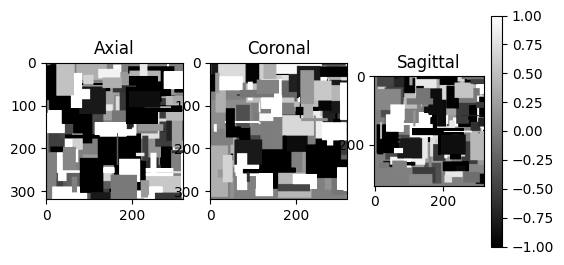

In [10]:
sim_gt_full = simulate_susceptibility_sources(simulation_dim = 320, rectangles_total = 800, spheres_total = 80,)
view_slices_3d(sim_gt_full, slice_nbr=100, vmin=-1, vmax=1)



## Convolve Susceptibility Distribution with Dipole Kernel to yield Tissue Phase

In [11]:
def generate_3d_dipole_kernel(data_shape, voxel_size, b_vec):
    fov = np.array(data_shape) * np.array(voxel_size)

    ry, rx, rz = np.meshgrid(np.arange(-data_shape[1] // 2, data_shape[1] // 2),
                             np.arange(-data_shape[0] // 2, data_shape[0] // 2),
                             np.arange(-data_shape[2] // 2, data_shape[2] // 2))

    rx, ry, rz = rx / fov[0], ry / fov[1], rz / fov[2]

    sq_dist = rx ** 2 + ry ** 2 + rz ** 2
    sq_dist[sq_dist == 0] = 1e-6
    d2 = ((b_vec[0] * rx + b_vec[1] * ry + b_vec[2] * rz) ** 2) / sq_dist
    kernel = (1 / 3 - d2)

    return kernel
    #加载三维偶极子核

In [12]:
dipole_kernel = generate_3d_dipole_kernel((64,64,64), voxel_size=1, b_vec=[0, 0, 1])
print(dipole_kernel.shape)

(64, 64, 64)


Matrix size: (64, 64, 64)


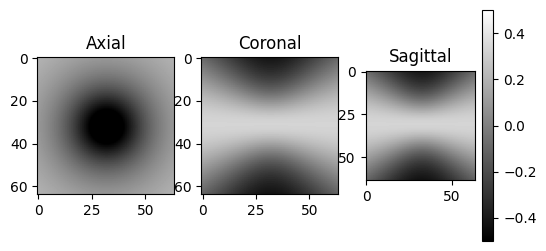

In [13]:
view_slices_3d(dipole_kernel, slice_nbr=50, vmin=-0.5, vmax=0.5)

In [14]:
def forward_convolution_padding(chi_sample, padding=20):
    #pad sample to avoid wrap-around at the edges
    padded_sample = np.zeros((chi_sample.shape[0]+2*padding, chi_sample.shape[1]+2*padding, chi_sample.shape[2]+2*padding))
    padded_sample[padding:chi_sample.shape[0]+padding, padding:chi_sample.shape[1]+padding, padding:chi_sample.shape[2]+padding] = chi_sample
    scaling = np.sqrt(padded_sample.size)
    chi_fft = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(padded_sample))) / scaling

    dipole_kernel = generate_3d_dipole_kernel(padded_sample.shape, voxel_size=1, b_vec=[0, 0, 1])

    chi_fft_t_kernel = chi_fft * dipole_kernel

    tissue_phase_unscaled = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(chi_fft_t_kernel)))
    tissue_phase = np.real(tissue_phase_unscaled * scaling)

    tissue_phase_cropped = tissue_phase[padding:chi_sample.shape[0]+padding, padding:chi_sample.shape[1]+padding, padding:chi_sample.shape[2]+padding]

    return tissue_phase_cropped

    #先对样本进行padding，在计算fft，归一化，生成三维偶极子核来和fft后的样本相乘
    #再计算逆FFT，归一化；对结果进行剪裁，最终生成组织相位数据（裁剪过）


def forward_convolution(chi_sample):
    scaling = np.sqrt(chi_sample.size)
    chi_fft = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(chi_sample))) / scaling

    chi_fft_t_kernel = chi_fft * generate_3d_dipole_kernel(chi_sample.shape, voxel_size=1, b_vec=[0, 0, 1])

    tissue_phase = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(chi_fft_t_kernel)))
    tissue_phase = np.real(tissue_phase * scaling)

    return tissue_phase
#上面的函数去除了padding，直接在原始样本上卷积，计算MRI组织相位数据
sim_fw_full = forward_convolution(sim_gt_full)

Matrix size: (320, 320, 320)


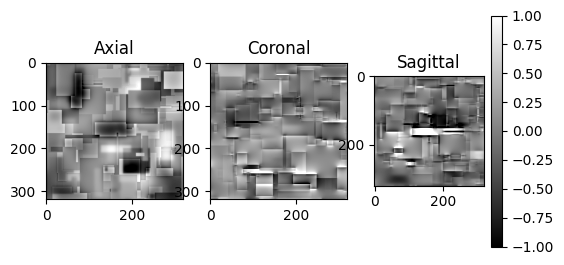

In [15]:
view_slices_3d(sim_fw_full, slice_nbr=100, vmin=-1, vmax=1)

Matrix size: (320, 320, 320)


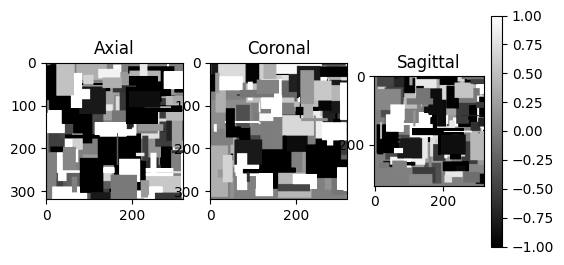

In [16]:
view_slices_3d(sim_gt_full, slice_nbr=100, vmin=-1, vmax=1)

#Train a model to invert the dipole convolution using Keras & Tensorflow

## Prepare patches for training

Due to memory limits on the GPUs and to get more training examples we will cut smaller patches from our simulated data



In [17]:
def cut_patch(dim, patch_idx, gt_full, fw_full):
    x_max, y_max, z_max = gt_full.shape

    randomX = np.random.randint(0, x_max - training_dim)
    randomY = np.random.randint(0, y_max - training_dim)
    randomZ = np.random.randint(0, z_max - training_dim)

    gt_patch = gt_full[randomX:randomX + training_dim, randomY:randomY + training_dim, randomZ:randomZ + training_dim]
    fw_patch = fw_full[randomX:randomX + training_dim, randomY:randomY + training_dim, randomZ:randomZ + training_dim]

    return gt_patch, fw_patch
    #因为GPU的内存限制，这边选择生成三维的patch用于训练

In [18]:

patches_total = 500
training_dim = 64
import numpy as np
# Cut patches from our simulations for training
sim_gt_patches = np.zeros((500, training_dim, training_dim, training_dim))
sim_fw_patches = np.zeros((500, training_dim, training_dim, training_dim))

for patch_idx in range(500):
  sim_gt_patches[patch_idx, :, :, :], sim_fw_patches[patch_idx, :, :, :] = cut_patch(training_dim, patch_idx, sim_gt_full, sim_fw_full)

# Cut test data patches from a real brain
brain_gt_patches = np.zeros((patches_total, training_dim, training_dim, training_dim))
brain_fw_patches = np.zeros((patches_total, training_dim, training_dim, training_dim))
for patch_idx in range(patches_total):
  brain_gt_patches[patch_idx, :, :, :], brain_fw_patches[patch_idx, :, :, :] = cut_patch(training_dim, patch_idx, brain_gt_full, brain_fw_full)
  #调用此前生成小块的函数，进一步裁剪出三维的小块，500个64^3的三维小块
  #上面是生成模拟小块，下面是生成真实小块

mix_gt_patches = np.concatenate((sim_gt_patches[0:250], brain_gt_patches[0:250]), axis=0)
mix_fw_patches = np.concatenate((sim_fw_patches[0:250], brain_fw_patches[0:250]), axis=0)

print(sim_gt_patches.shape)

(500, 64, 64, 64)


Matrix size: (64, 64, 64)
Matrix size: (64, 64, 64)


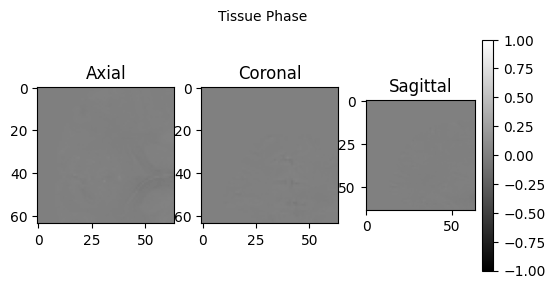

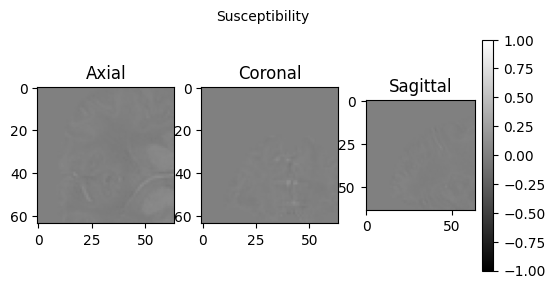

In [19]:
patch_idx = 44
view_slices_3d(brain_fw_patches[patch_idx, :, :, :], slice_nbr=16, vmin=-1, vmax=1, title='Tissue Phase')
view_slices_3d(brain_gt_patches[patch_idx, :, :, :], slice_nbr=16, vmin=-1, vmax=1, title='Susceptibility')
#随机选取一个小切片进行观测

## Build a model
based on
* https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/r2/tutorials/generative/pix2pix.ipynb#scrollTo=tqqvWxlw8b4l


* https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/07_Keras_Flowers_TPU_squeezenet.ipynb#scrollTo=MPkvHdAYNt9J

In [20]:

import tensorflow as tf
print(tf.__version__)
device_name = tf.test.gpu_device_name()

#if device_name != '/device:GPU:0':
  #raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.15.1
Found GPU at: /device:GPU:0


In [21]:
OUTPUT_CHANNELS = 1

def downsample(filters, kernel_size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv3D(filters, kernel_size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result
 #定义下采样函数，三维CNN，条件性添加BN层

In [22]:
# bringing things in the right shape for the network (first dimension is batch, then xyz, last dimension is channel)
inp = sim_fw_patches[ 0, :, :, :]
print(inp.shape)
inp = tf.expand_dims(inp, 0)
print(inp.shape)
inp = tf.expand_dims(inp, 4)
print(inp.shape)

(64, 64, 64)
(1, 64, 64, 64)
(1, 64, 64, 64, 1)


In [23]:
# testing downsample part
down_model = downsample(filters=8, kernel_size=4)
down_result = down_model(inp)
print (down_result.shape)

(1, 32, 32, 32, 8)


In [24]:
def upsample(filters, kernel_size, apply_dropout=False, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv3DTranspose(filters, kernel_size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  if apply_batchnorm:
      result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result
  #上采样

In [25]:
# Testing upsample part
up_model = upsample(filters=8, kernel_size=4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 64, 64, 64, 8)


In [26]:
# Parameters for all Models
import pickle


epochs_train = 150
save_period = 30


# Train Model 1

## Prepare

In [24]:
import tensorflow as tf

def upsample(filters, kernel_size, apply_dropout=False, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv3DTranspose(filters, kernel_size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

def downsample(filters, kernel_size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv3D(filters, kernel_size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def Attention_block(F_g, F_l, F_int):
    g_conv = tf.keras.layers.Conv3D(F_g, kernel_size=1, strides=1, padding='same')

    x_conv = tf.keras.layers.Conv3D(F_l, kernel_size=1, strides=1, padding='same')
    psi = tf.keras.layers.Conv3D(F_int, kernel_size=1, strides=1, padding='same')
    def func(g, x):
        g1 = g_conv(g)
        x1 = x_conv(x)
        psi_val = tf.nn.relu(g1 + x1)
        psi_val = psi(psi_val)
        psi_val = tf.nn.sigmoid(psi_val)

        return x * psi_val

    return func
    '''class Attention_block(nn.Module):
      def __init__(self,F_g,F_l,F_int):
          super(Attention_block,self).__init__()
          self.W_g = nn.Sequential(
              nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
              nn.BatchNorm2d(F_int)
              )

          self.W_x = nn.Sequential(
              nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
              nn.BatchNorm2d(F_int)
          )

          self.psi = nn.Sequential(
              nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
              nn.BatchNorm2d(1),
              nn.Sigmoid()
          )

          self.relu = nn.ReLU(inplace=True)'''

def AttentionUNet(filter_base=32, kernel_size=3):
    down_stack = [
        downsample(filter_base, kernel_size, apply_batchnorm=False),
        downsample(filter_base*2, kernel_size),
        downsample(filter_base*3, kernel_size),
        downsample(filter_base*4, kernel_size),
        downsample(filter_base*5, kernel_size)
    ]

    up_stack = [
        upsample(filter_base*5, kernel_size, apply_dropout=True),
        upsample(filter_base*4, kernel_size, apply_dropout=True),
        upsample(filter_base*3, kernel_size),
        upsample(filter_base*2, kernel_size)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv3DTranspose(1, kernel_size,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')

    inputs = tf.keras.layers.Input(shape=[None,None,None,1])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Attention Blocks
    attention_blocks = [Attention_block(filters*2, filters*2, filters) for filters in [filter_base*4, filter_base*3, filter_base*2, filter_base]]

    # Upsampling and establishing the skip connections with attention
    for up, skip, attention_block in zip(up_stack, skips, attention_blocks):
        x = up(x)
        x = tf.keras.layers.concatenate([x, skip])
        x = attention_block(x, skip)

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [28]:
!pip install tfkan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [1]:
import tensorflow as tf
#非该网页自带upsample，downsample
def upsample(filters, kernel_size, apply_dropout=False, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv3DTranspose(filters, kernel_size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

def downsample(filters, kernel_size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv3D(filters, kernel_size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def Attention_block(F_g, F_l, F_int):
    g_conv = tf.keras.layers.Conv3D(F_g, kernel_size=1, strides=1, padding='same')
    x_conv = tf.keras.layers.Conv3D(F_l, kernel_size=1, strides=1, padding='same')
    psi = tf.keras.layers.Conv3D(F_int, kernel_size=1, strides=1, padding='same')
    def func(g, x):
        g1 = g_conv(g)
        x1 = x_conv(x)
        psi_val = tf.nn.relu(g1 + x1)
        psi_val = psi(psi_val)
        psi_val = tf.nn.sigmoid(psi_val)

        return x * psi_val

    return func

def AttentionUNet(filter_base=32, kernel_size=3):
    down_stack = [
        downsample(filter_base, kernel_size, apply_batchnorm=False),
        downsample(filter_base*2, kernel_size),
        downsample(filter_base*3, kernel_size),
        downsample(filter_base*4, kernel_size),
        downsample(filter_base*5, kernel_size)
    ]

    up_stack = [
        upsample(filter_base*5, kernel_size, apply_dropout=True),
        upsample(filter_base*4, kernel_size, apply_dropout=True),
        upsample(filter_base*3, kernel_size),
        upsample(filter_base*2, kernel_size)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv3DTranspose(1, kernel_size,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')

    inputs = tf.keras.layers.Input(shape=[None,None,None,1])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Attention Blocks
    attention_blocks = [Attention_block(filters*2, filters*2, filters) for filters in [filter_base*4, filter_base*3, filter_base*2, filter_base]]

    # Upsampling and establishing the skip connections with attention
    for up, skip, attention_block in zip(up_stack, skips, attention_blocks):
        x = up(x)
        x = tf.keras.layers.concatenate([x, skip])
        x = attention_block(x, skip)

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


def upsample(filters, kernel_size, apply_dropout=False, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv3DTranspose(filters, kernel_size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

def downsample(filters, kernel_size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv3D(filters, kernel_size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def encoder_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    x = conv3d_block(input_tensor, n_filters, kernel_size=kernel_size, batchnorm=batchnorm)
    x = conv3d_block(x, n_filters, kernel_size=kernel_size, batchnorm=batchnorm)
    return x

def conv3d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    x = layers.Conv3D(filters=n_filters, kernel_size=(kernel_size, kernel_size, kernel_size), padding="same")(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def decoder_block(input_tensor, concat_tensor, n_filters, kernel_size=3, strides=2, batchnorm=True, dropout_rate=0):
    x = layers.Conv3DTranspose(filters=n_filters, kernel_size=(kernel_size, kernel_size, kernel_size), strides=(strides, strides, strides), padding="same")(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Concatenate()([x, concat_tensor])
    x = conv3d_block(x, n_filters, kernel_size=kernel_size, batchnorm=batchnorm, dropout_rate=dropout_rate)
    return conv3d_block(x, n_filters, kernel_size=kernel_size, batchnorm=batchnorm, dropout_rate=dropout_rate)

import tensorflow as tf

from tfkan.layers import Conv3DKAN
def DepthwiseConv3D(input_tensor, kernel_size, padding='same'):
    input_channels = input_tensor.shape[-1]
    depthwise_convs = []

    for i in range(input_channels):
        channel = tf.keras.layers.Lambda(lambda x: x[..., i:i+1])(input_tensor)
        conv = tf.keras.layers.Conv3D(filters=1, kernel_size=kernel_size, padding=padding)(channel)
        depthwise_convs.append(conv)

    x = tf.keras.layers.Concatenate()(depthwise_convs)
    return x

def TokKANBlock(input_tensor, filters, kernel_size=(3, 3, 3), strides=(1, 1, 1), grid_size=3, spline_order=3):
    # 第一层标准 3D 卷积
    x = tf.keras.layers.Conv3D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(input_tensor)

    # 第二层使用 KAN 的 3D 卷积
    x = Conv3DKAN(filters=filters, kernel_size=kernel_size, strides=strides, padding='same',
                   kan_kwargs={'grid_size': grid_size,'spline_order':spline_order}, )(x)

    # 第三层深度卷积
    x = tf.keras.layers.Conv3D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(input_tensor)

    # 最后一层归一化
    x = tf.keras.layers.LayerNormalization()(x)

    return x

def encoder_block1(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    x = conv3d_block(input_tensor, n_filters, kernel_size=kernel_size, batchnorm=batchnorm)
    return x

def conv3d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    x = layers.Conv3D(filters=n_filters, kernel_size=(kernel_size, kernel_size, kernel_size), padding="same")(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def decoder_block1(input_tensor, concat_tensor, n_filters, kernel_size=3, strides=2, batchnorm=True, dropout_rate=0):
    x = layers.Conv3DTranspose(filters=n_filters, kernel_size=(kernel_size, kernel_size, kernel_size), strides=(strides, strides, strides), padding="same")(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Concatenate()([x, concat_tensor])
    x = conv3d_block(x, n_filters, kernel_size=kernel_size, batchnorm=batchnorm)
    return x

In [ ]:

def autoQSM(n_filters=16, n_classes=1, dropout_rate=0):
    inputs = tf.keras.layers.Input(shape=[None, None, None, 1])

    # Encoder
    conv1 = encoder_block(inputs, n_filters * 1)
    pool1 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = encoder_block(pool1, n_filters * 2)
    pool2 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = encoder_block(pool2, n_filters * 4)
    pool3 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    # Bridge
    conv4 = encoder_block(pool3, n_filters * 8, dropout_rate=dropout_rate)
    # Decoder
    deconv5 = decoder_block(conv4, conv3, n_filters * 4, dropout_rate=dropout_rate)
    deconv6 = decoder_block(deconv5, conv2, n_filters * 2, dropout_rate=dropout_rate)
    deconv7 = decoder_block(deconv6, conv1, n_filters * 1, dropout_rate=dropout_rate)

    outputs = tf.keras.layers.Conv3D(n_classes, (1, 1, 1), activation="tanh")(deconv7)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:

def dl_model_delta(n_filters=16, n_classes=1, dropout_rate=0):
    inputs = tf.keras.layers.Input(shape=[None, None, None, 1])

    # Encoder
    conv1 = encoder_block(inputs, n_filters * 1, dropout_rate=dropout_rate)
    pool1 = downsample_block(conv1, n_filters * 2)

    conv2 = encoder_block(pool1, n_filters * 2, dropout_rate=dropout_rate)
    pool2 = downsample_block(conv2, n_filters * 4)

    conv3 = encoder_block(pool2, n_filters * 4, dropout_rate=dropout_rate)
    pool3 = downsample_block(conv3, n_filters * 8)

    # Bridge
    conv4 = encoder_block(pool3, n_filters * 8, dropout_rate=dropout_rate)
    # Decoder
    deconv5 = decoder_block(conv4, conv3, n_filters * 4, dropout_rate=dropout_rate)
    deconv6 = decoder_block(deconv5, conv2, n_filters * 2, dropout_rate=dropout_rate)
    deconv7 = decoder_block(deconv6, conv1, n_filters * 1, dropout_rate=dropout_rate)

    outputs = layers.Conv3D(n_classes, (1, 1, 1), activation="tanh")(deconv7)

    return tf.keras.Model(inputs=inputs, outputs=outputs)



In [2]:
import tensorflow as tf
from tensorflow.keras import layers

from tfkan.layers import DenseKAN, Conv3DKAN

def autoKAN(n_filters=16, n_classes=1, dropout_rate=0, grid_size=3, spline_order=3):
    inputs = tf.keras.layers.Input(shape=[None, None, None, 1])

    # Encoder
    conv1 = encoder_block1(inputs, n_filters * 1)
    pool1 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = encoder_block1(pool1, n_filters * 2)
    pool2 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = encoder_block1(pool2, n_filters * 4)
    pool3 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    # Tok-KAN block
    tok_kan4 = TokKANBlock(pool3, filters=n_filters * 8, kernel_size=(3, 3, 3), strides=(1, 1, 1), grid_size=grid_size, spline_order=spline_order)

    # Decoder
    deconv5 = decoder_block1(tok_kan4, conv3, n_filters * 4)
    deconv6 = decoder_block1(deconv5, conv2, n_filters * 2)
    deconv7 = decoder_block1(deconv6, conv1, n_filters * 1)

    # Output layer
    outputs = tf.keras.layers.Conv3D(n_classes, (1, 1, 1), activation="tanh")(deconv7)

    return tf.keras.Model(inputs=inputs, outputs=outputs)


In [3]:
import tensorflow as tf
import numpy as np
import os
import pickle
from keras.optimizers import Adam

model1 = autoKAN()
model1.compile(optimizer=Adam(lr=1e-4), loss='mse')
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, None,    0         []                            
                             1)]                                                                  
                                                                                                  
 conv3d (Conv3D)             (None, None, None, None, 1   448       ['input_1[0][0]']             
                             6)                                                                   
                                                                                                  
 batch_normalization (Batch  (None, None, None, None, 1   64        ['conv3d[0][0]']              
 Normalization)              6)                                                               

(1, 64, 64, 64, 1)
1/1 [==============================] - 1s 1s/step
Matrix size: (64, 64, 64)
Matrix size: (64, 64, 64)
Matrix size: (64, 64, 64)


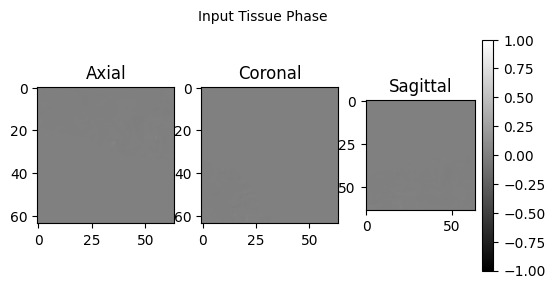

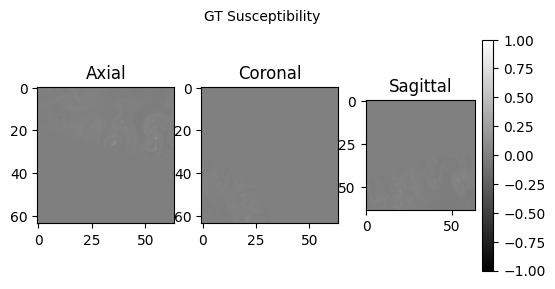

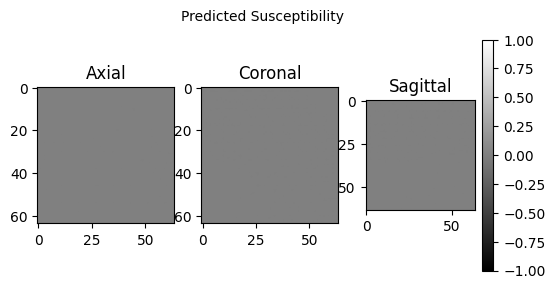

In [27]:
# what does the untrained model predict
test_patch_nbr = 10
X_test = brain_fw_patches[np.newaxis, test_patch_nbr,:,:,:, np.newaxis]
print(X_test.shape)
kernel = generate_3d_dipole_kernel((64,64,64), voxel_size=1, b_vec=[0, 0, 1])
dipole_kernel = np.expand_dims(kernel, axis=0)  # 在第一个轴上扩展
dipole_kernel = np.expand_dims(dipole_kernel, axis=-1)  # 在最后一个轴上扩展
y_pred = model1.predict(X_test)
'''y_pred = model1.predict(X_test）'''


view_slices_3d(X_test[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Input Tissue Phase')
view_slices_3d(brain_gt_patches[test_patch_nbr, :, :, :], slice_nbr=16, vmin=-1, vmax=1, title='GT Susceptibility')
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Predicted Susceptibility')


## Train

In [ ]:
import os

## Load and Plot

In [28]:
checkpoint_path1 = "checkpoints1/cp-{epoch:04d}.ckpt"
checkpoint_dir1 = os.path.dirname(checkpoint_path1)

# 创建检查点回调
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path1,
    save_weights_only=True,
    save_freq='epoch',  # 使用 save_freq 而不是 period
    verbose=1
)
'''
dipole_kernel = generate_3d_dipole_kernel((64, 64, 64), voxel_size=1, b_vec=[0, 0, 1])
dipole_kernel = np.expand_dims(dipole_kernel, axis=0)  # 在第一个轴上扩展
dipole_kernel = np.expand_dims(dipole_kernel, axis=-1)  # 在最后一个轴上扩展
dipole_kernel_batch = np.repeat(dipole_kernel, 500, axis=0)
print(dipole_kernel_batch.shape)
'''

phase_images = tf.expand_dims(brain_fw_patches * 10, 4)
susceptibility_labels = tf.expand_dims(brain_gt_patches * 10, 4)

#train_images = [phase_images, dipole_kernel_batch]
#train_labels = [susceptibility_labels, phase_images]

train_images = phase_images
train_labels = susceptibility_labels
history1 = model1.fit(
    train_images,
    train_labels,
    epochs=epochs_train,
    batch_size=8,
    shuffle=True,
    callbacks=[cp_callback]  # 传递回调以保存模型
)



loss_history1 = history1.history['loss']

with open('loss_history1.pickle', 'wb') as f:
    pickle.dump([loss_history1, epochs_train], f)
    pickle.dump([loss_history1, epochs_train], f)

Epoch 1/150
63/63 [==============================] - ETA: 0s - loss: 0.0546
Epoch 1: saving model to checkpoints1/cp-0001.ckpt
63/63 [==============================] - 42s 381ms/step - loss: 0.0546
Epoch 2/150
63/63 [==============================] - ETA: 0s - loss: 0.0276
Epoch 2: saving model to checkpoints1/cp-0002.ckpt
63/63 [==============================] - 20s 310ms/step - loss: 0.0276
Epoch 3/150
63/63 [==============================] - ETA: 0s - loss: 0.0241
Epoch 3: saving model to checkpoints1/cp-0003.ckpt
63/63 [==============================] - 20s 316ms/step - loss: 0.0241
Epoch 4/150
63/63 [==============================] - ETA: 0s - loss: 0.0210
Epoch 4: saving model to checkpoints1/cp-0004.ckpt
63/63 [==============================] - 20s 311ms/step - loss: 0.0210
Epoch 5/150
63/63 [==============================] - ETA: 0s - loss: 0.0193
Epoch 5: saving model to checkpoints1/cp-0005.ckpt
63/63 [==============================] - 19s 307ms/step - loss: 0.0193
Epoch 6/15

KeyboardInterrupt: 

In [ ]:
# load stored data
checkpoint_path1 = "checkpoints1/cp-{epoch:04d}.ckpt"
checkpoint_dir1 = os.path.dirname(checkpoint_path1)

# Print the checkpoint directory to ensure it's correct
print("Checkpoint Directory:", checkpoint_dir1)

# Create the directory if it doesn't exist
if not os.path.exists(checkpoint_dir1):
    os.makedirs(checkpoint_dir1)

# Ensure model is compiled before trying to load weights


# Check for the latest checkpoint
latest1 = tf.train.latest_checkpoint(checkpoint_dir1)
print("Latest Checkpoint:", latest1)

# Load weights if a checkpoint is found
if latest1:
    model1.load_weights(latest1)
else:
    print("No checkpoint found at ", checkpoint_dir1)



if latest1:
    model1.load_weights(latest1)
else:
    print("No checkpoint found at ", checkpoint_dir1)





with open('loss_history1.pickle', 'rb') as f:
    [loss_history1, epochs_train1] = pickle.load(f)

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on.
    Removes top and right border and ticks, because those are ugly
    """
    fig, ax = plt.subplots(1)
    plt.tick_params(top=False, right=False, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

fig, ax = get_figure()

ax.plot(np.arange(epochs_train1) + 1, loss_history1, marker="o", linewidth=2, color="orange", label="loss1")
ax.set_xlabel('epoch')
ax.legend(frameon=False);


Checkpoint Directory: checkpoints1
Latest Checkpoint: checkpoints1/cp-0005.ckpt


Latest Checkpoint: checkpoints1/cp-0103.weights.h5


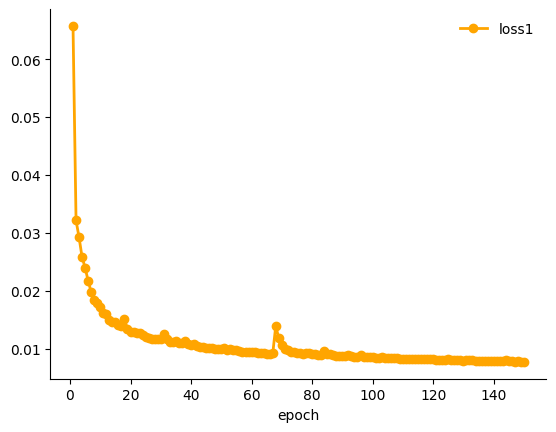

In [75]:
import glob
import os
import pickle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# 找到所有 .h5 文件
h5_files = glob.glob(os.path.join(checkpoint_dir1, "*.weights.h5"))

if h5_files:
    # 按文件名排序，假设文件名中包含数字表示epoch
    latest1 = max(h5_files, key=os.path.getctime)  # 也可以用os.path.getmtime
    print("Latest Checkpoint:", latest1)
    model1.load_weights(latest1)
else:
    print("No checkpoint found at ", checkpoint_dir1)

with open('loss_history1.pickle', 'rb') as f:
    [loss_history1, epochs_train1] = pickle.load(f)

# Function to create a figure for plotting
def get_figure():
    """
    Returns figure and axis objects to plot on.
    Removes top and right border and ticks, because those are ugly
    """
    fig, ax = plt.subplots(1)
    plt.tick_params(top=False, right=False, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

# Plot the training history
fig, ax = get_figure()
ax.plot(np.arange(epochs_train1) + 1, loss_history1, marker="o", linewidth=2, color="orange", label="loss1")
ax.set_xlabel('epoch')
ax.legend(frameon=False)
plt.show()

(1, 64, 64, 64, 1)
1/1 [==============================] - 0s 103ms/step
(1, 64, 64, 64, 1)
Matrix size: (64, 64, 64)
Matrix size: (64, 64, 64)
Matrix size: (64, 64, 64)


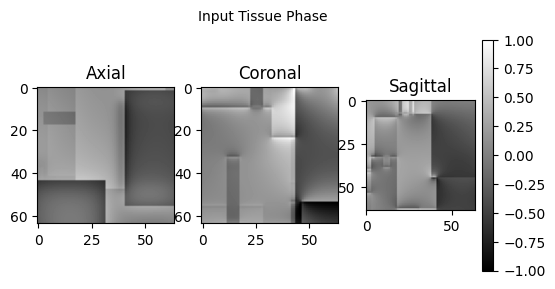

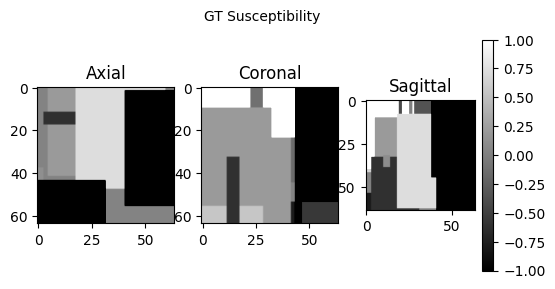

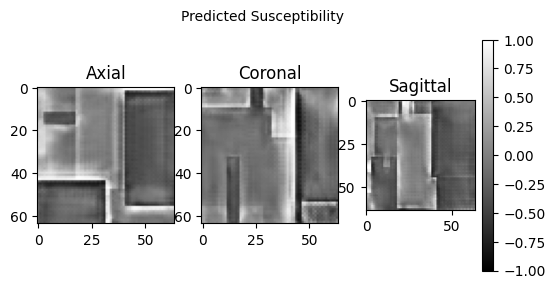

In [77]:
# did we manage to learn the training data?
test_patch_nbr = 4
X_test = sim_fw_patches[np.newaxis, test_patch_nbr,:,:,:, np.newaxis]
print(X_test.shape)

'''y_pred = model1.predict([X_test,dipole_kernel])'''
'''y_pred = model1.predict(X_test)'''
y_pred = model1.predict(X_test)

print(y_pred.shape)

view_slices_3d(X_test[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Input Tissue Phase')
view_slices_3d(sim_gt_patches[test_patch_nbr, :, :, :], slice_nbr=16, vmin=-1, vmax=1, title='GT Susceptibility')
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Predicted Susceptibility')


In [78]:
# and predicting on the full data?
X_test = sim_fw_full[np.newaxis, :, :, :, np.newaxis]
print(X_test.shape)

y_pred = model1.predict(X_test)

print(y_pred.shape)

view_slices_3d(X_test[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Input Tissue Phase')
view_slices_3d(sim_gt_full[:, :, :], slice_nbr=16, vmin=-1, vmax=1, title='GT Susceptibility')
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Predicted Susceptibility')


(1, 320, 320, 320, 1)


ResourceExhaustedError: Graph execution error:

Detected at node model_2/conv3d_transpose_11/conv3d_transpose defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-78-0da8f3b29606>", line 5, in <cell line: 5>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2655, in predict

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/conv3d_transpose.py", line 314, in call

OOM when allocating tensor with shape[1,16,320,320,320] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_2/conv3d_transpose_11/conv3d_transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_65670]

(1, 160, 160, 160, 1)
1/1 [==============================] - 0s 91ms/step
(1, 160, 160, 160, 1)
Matrix size: (160, 160, 160)
Matrix size: (160, 160, 160)
Matrix size: (160, 160, 160)


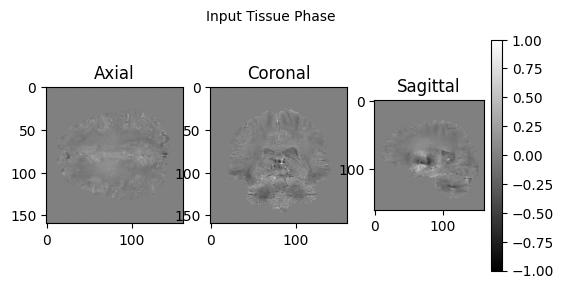

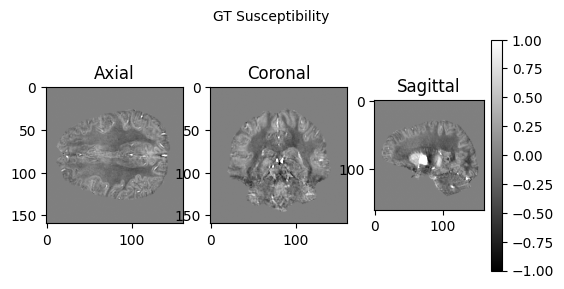

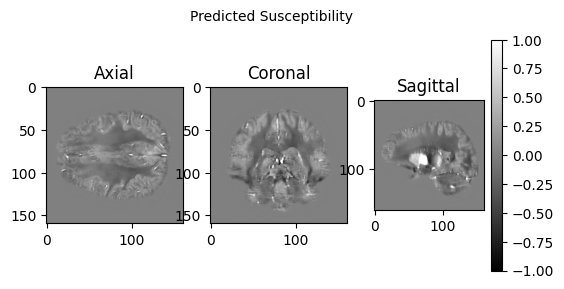

In [83]:
# and predicting on the brain data?
import scipy.ndimage

X_test = brain_fw_full[np.newaxis,:,:,:,np.newaxis] * 10

print(X_test.shape)

y_pred = model1.predict(X_test)

print(y_pred.shape)

view_slices_3d(X_test[0, :, :, :, 0], slice_nbr=100, vmin=-1, vmax=1, title='Input Tissue Phase')
view_slices_3d(brain_gt_full[:,:,:,]*10, slice_nbr=100, vmin=-1, vmax=1, title='GT Susceptibility')
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=100, vmin=-1, vmax=1, title='Predicted Susceptibility')

In [ ]:
def predict_large_image(model, large_image, dipole_kernel, block_size=(64, 64, 64)):
    # 获取大图像的尺寸
    z, y, x = large_image.shape[1], large_image.shape[2], large_image.shape[3]
    bz, by, bx = block_size
    result = np.zeros((z, y, x, 1))

    for i in range(0, z, bz):
        for j in range(0, y, by):
            for k in range(0, x, bx):
                # 提取块
                block = large_image[:,i:i+bz, j:j+by, k:k+bx,:]
                block_kernel = dipole_kernel
                # 预测
                result_block = model.predict([block, block_kernel])
                # 存储结果
                result[i:i+bz, j:j+by, k:k+bx, :] = result_block[0]

    return result

import scipy.ndimage
kernel = generate_3d_dipole_kernel((64,64,64), voxel_size=1, b_vec=[0, 0, 1])
dipole_kernel = np.expand_dims(kernel, axis=0)  # 在第一个轴上扩展
dipole_kernel = np.expand_dims(dipole_kernel, axis=-1)  # 在最后一个轴上扩展
X_test = brain_fw_full[np.newaxis,:,:,:,np.newaxis] * 10
y_pred = predict_large_image(model1, X_test, dipole_kernel)
view_slices_3d(X_test[0, :, :, :, 0], slice_nbr=100, vmin=-1, vmax=1, title='Input Tissue Phase')
view_slices_3d(brain_gt_full[:,:,:,]*10, slice_nbr=100, vmin=-1, vmax=1, title='GT Susceptibility')
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=100, vmin=-1, vmax=1, title='Predicted Susceptibility')


In [ ]:
# and predicting on the brain data?
X_test = brain_fw_full[np.newaxis, :, :, :, np.newaxis] * 10
print(X_test.shape)

y_pred = model1.predict(X_test)

print(y_pred.shape)

view_slices_3d(X_test[0, :, :, :, 0], slice_nbr=100, vmin=-1, vmax=1, title='Input Tissue Phase')
view_slices_3d(brain_gt_full[:, :, :]*10, slice_nbr=100, vmin=-1, vmax=1, title='GT Susceptibility')
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=100, vmin=-1, vmax=1, title='Predicted Susceptibility')

# Train Model 2

## Prepare

In [29]:
import tensorflow as tf
from tfkan.layers import Conv3DKAN

def TokKANBlock(input_tensor, filters, kernel_size=(3, 3, 3), strides=(1, 1, 1), grid_size=3, spline_order=3):
    # 第一层标准 3D 卷积
    x = tf.keras.layers.Conv3D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(input_tensor)

    # 第二层使用 KAN 的 3D 卷积
    x = Conv3DKAN(filters=filters, kernel_size=kernel_size, strides=strides, padding='same',
                  grid_size=grid_size, spline_order=spline_order)(x)

    # 第三层深度卷积
    x = tf.keras.layers.DepthwiseConv3D(kernel_size=(3, 3, 3), padding='same')(x)

    # 最后一层归一化
    x = tf.keras.layers.LayerNormalization()(x)

    return x

def encoder_block1(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    x = conv3d_block(input_tensor, n_filters, kernel_size=kernel_size, batchnorm=batchnorm)
    return x

def conv3d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    x = layers.Conv3D(filters=n_filters, kernel_size=(kernel_size, kernel_size, kernel_size), padding="same")(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def decoder_block1(input_tensor, concat_tensor, n_filters, kernel_size=3, strides=2, batchnorm=True, dropout_rate=0):
    x = layers.Conv3DTranspose(filters=n_filters, kernel_size=(kernel_size, kernel_size, kernel_size), strides=(strides, strides, strides), padding="same")(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Concatenate()([x, concat_tensor])
    x = conv3d_block(x, n_filters, kernel_size=kernel_size, batchnorm=batchnorm, dropout_rate=dropout_rate)
    return x


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tfkan import layers
from tfkan.layers import DenseKAN, Conv3DKAN

def autoKAN(n_filters=16, n_classes=1, dropout_rate=0, grid_size=3, spline_order=3):
    inputs = tf.keras.layers.Input(shape=[None, None, None, 1])

    # Encoder
    conv1 = encoder_bloc1(inputs, n_filters * 1, dropout_rate=dropout_rate)
    pool1 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = encoder_block1(pool1, n_filters * 2, dropout_rate=dropout_rate)
    pool2 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = encoder_block1(pool2, n_filters * 4, dropout_rate=dropout_rate)
    pool3 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    # Tok-KAN block
    tok_kan4 = TokKANBlock(pool3, filters=n_filters * 8, kernel_size=(3, 3, 3), strides=(1, 1, 1), grid_size=grid_size, spline_order=spline_order)

    # Decoder
    deconv5 = decoder_block1(tok_kan4, conv3, n_filters * 4, dropout_rate=dropout_rate)
    deconv6 = decoder_block1(deconv5, conv2, n_filters * 2, dropout_rate=dropout_rate)
    deconv7 = decoder_block1(deconv6, conv1, n_filters * 1, dropout_rate=dropout_rate)

    # Output layer
    outputs = layers.Conv3D(n_classes, (1, 1, 1), activation="tanh")(deconv7)

    return tf.keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
def autoQSM_with_tok_kan(n_filters=16, n_classes=1, dropout_rate=0):
    inputs = tf.keras.layers.Input(shape=[None, None, None, 1])

    # Encoder
    conv1 = encoder_block(inputs, n_filters * 1, dropout_rate=dropout_rate)
    pool1 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = encoder_block(pool1, n_filters * 2, dropout_rate=dropout_rate)
    pool2 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    # Tok-KAN Integration
    tok_kan1 = TokKAN3DLayer(n_filters * 4)(pool2)  # 替代 conv3
    tok_kan2 = TokKAN3DLayer(n_filters * 4)(tok_kan1)  # 替代 pool3
    tok_kan3 = TokKAN3DLayer(n_filters * 4)(tok_kan2)  # 替代 conv4
    tok_kan4 = TokKAN3DLayer(n_filters * 4)(tok_kan3)  # 替代 deconv5

    # Decoder
    deconv6 = decoder_block(tok_kan4, conv2, n_filters * 2, dropout_rate=dropout_rate)
    deconv7 = decoder_block(deconv6, conv1, n_filters * 1, dropout_rate=dropout_rate)

    outputs = layers.Conv3D(n_classes, (1, 1, 1), activation="tanh")(deconv7)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow as tf

def generate_dynamic_dipole_kernel(shape_tensor, voxel_size=1, b_vec=[0, 0, 1]):
    # 提取形状并确保是整数
    shape_tensor = tf.cast(shape_tensor, tf.int32)
    fov = tf.cast(shape_tensor, tf.float32) * tf.cast(voxel_size, tf.float32)

    # 生成网格并确保num参数为整数
    num_x = tf.cast(shape_tensor[0], tf.int32)
    num_y = tf.cast(shape_tensor[1], tf.int32)
    num_z = tf.cast(shape_tensor[2], tf.int32)

    grid_x = tf.linspace(-fov[0] / 2, fov[0] / 2, num=num_x)
    grid_y = tf.linspace(-fov[1] / 2, fov[1] / 2, num=num_y)
    grid_z = tf.linspace(-fov[2] / 2, fov[2] / 2, num=num_z)

    rx, ry, rz = tf.meshgrid(grid_x, grid_y, grid_z, indexing='ij')

    # 归一化网格
    rx, ry, rz = rx / fov[0], ry / fov[1], rz / fov[2]

    # 计算偶极子核
    sq_dist = rx**2 + ry**2 + rz**2
    sq_dist = tf.where(sq_dist == 0, tf.ones_like(sq_dist) * 1e-6, sq_dist)
    d2 = (b_vec[0] * rx + b_vec[1] * ry + b_vec[2] * rz)**2 / sq_dist
    kernel = (1.0 / 3.0 - d2)

    return kernel
'''
def dl_model_physical_single_input(n_filters=16, n_classes=1, dropout_rate=0):
    inputs = layers.Input(shape=[None, None, None, 1])

    # 动态生成偶极子核
    dipole_kernel = layers.Lambda(
    lambda x: generate_dynamic_dipole_kernel(tf.shape(x)[1:4]),
    name='input_dipole',
    output_shape=lambda x: x
                    )(inputs)
    # 编码器
    conv1 = encoder_block(inputs, n_filters * 1, dropout_rate=dropout_rate)
    pool1 = downsample_block(conv1, n_filters * 2)

    conv2 = encoder_block(pool1, n_filters * 2, dropout_rate=dropout_rate)
    pool2 = downsample_block(conv2, n_filters * 4)

    conv3 = encoder_block(pool2, n_filters * 4, dropout_rate=dropout_rate)
    pool3 = downsample_block(conv3, n_filters * 8)

    # 桥接
    conv4 = encoder_block(pool3, n_filters * 8, dropout_rate=dropout_rate)

    # 解码器
    deconv5 = decoder_block(conv4, conv3, n_filters * 4, dropout_rate=dropout_rate)
    deconv6 = decoder_block(deconv5, conv2, n_filters * 2, dropout_rate=dropout_rate)
    deconv7 = decoder_block(deconv6, conv1, n_filters * 1, dropout_rate=dropout_rate)
    susceptibility_output = layers.Conv3D(n_classes, (1, 1, 1), activation="tanh")(deconv7)

    physical_output = layers.Lambda(
        physical_model_layer,
        arguments={'matrix_size': tf.shape(susceptibility_output)[1:4],'regularization_param': 0.05},
        name='physical_output',
        output_shape=lambda x: x[0]  # Output shape same as susceptibility_output
    )([susceptibility_output, dipole_kernel])


    model = models.Model(inputs=inputs, outputs=[susceptibility_output, physical_output])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer, loss='mse')

    return model
'''
def dl_model_physical_single_input(n_filters=16, n_classes=1, dropout_rate=0):
    inputs = layers.Input(shape=[None, None, None, 1])

    # 动态生成偶极子核
    dipole_kernel = layers.Lambda(
    lambda x: generate_dynamic_dipole_kernel(tf.shape(x)[1:4]),
    name='input_dipole',
    output_shape=lambda x: x
                    )(inputs)
    # 编码器
    conv1 = encoder_block(inputs, n_filters * 1, dropout_rate=dropout_rate)
    pool1 = downsample_block(conv1, n_filters * 2)

    conv2 = encoder_block(pool1, n_filters * 2, dropout_rate=dropout_rate)
    pool2 = downsample_block(conv2, n_filters * 4)

    conv3 = encoder_block(pool2, n_filters * 4, dropout_rate=dropout_rate)
    pool3 = downsample_block(conv3, n_filters * 8)

    # 桥接
    conv4 = encoder_block(pool3, n_filters * 8, dropout_rate=dropout_rate)

    # 解码器
    deconv5 = decoder_block(conv4, conv3, n_filters * 4, dropout_rate=dropout_rate)
    deconv6 = decoder_block(deconv5, conv2, n_filters * 2, dropout_rate=dropout_rate)
    deconv7 = decoder_block(deconv6, conv1, n_filters * 1, dropout_rate=dropout_rate)
    susceptibility_output = layers.Conv3D(n_classes, (1, 1, 1), activation="tanh")(deconv7)

    # Wrap physical_model_layer in a custom layer
    class PhysicalModelLayer(layers.Layer):
        def __init__(self,  regularization_param=0.05, **kwargs):
            super(PhysicalModelLayer, self).__init__(**kwargs)
            self.regularization_param = regularization_param

        def call(self, inputs):
            susceptibility, dipole_kernel = inputs
            # Get matrix size dynamically within call
            matrix_size = tf.shape(susceptibility)[1:4]
            return physical_model_layer([susceptibility, dipole_kernel], matrix_size, self.regularization_param)

    # Use the custom layer
    physical_output = PhysicalModelLayer(regularization_param=0.05, name='physical_output')([susceptibility_output, dipole_kernel])


    model = models.Model(inputs=inputs, outputs=[susceptibility_output, physical_output])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer, loss='mse')

    return model

model1 = dl_model_physical_single_input()
model1.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30            │ (None, None, None,     │              0 │ -                      │
│ (InputLayer)              │ None, 1)               │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_453 (Conv3D)       │ (None, None, None,     │            448 │ input_layer_30[0][0]   │
│                           │ None, 16)              │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_504   │ (None, None, None,     │             64 │ conv3d_453[0][0]       │
│ (BatchNormalization)      │ None, 16)              │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_427 (ReLU)          │ (None, None, None,     │              0 │ batch_normalization_5… │
│                           │ None, 16)              │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_454 (Conv3D)       │ (None, None, None,     │          6,928 │ re_lu_427[0][0]        │
│                           │ None, 16)              │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_505   │ (None, None, None,     │             64 │ conv3d_454[0][0]       │
│ (BatchNormalization)      │ None, 16)              │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_428 (ReLU)          │ (None, None, None,     │              0 │ batch_normalization_5… │
│                           │ None, 16)              │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_455 (Conv3D)       │ (None, None, None,     │          4,096 │ re_lu_428[0][0]        │
│                           │ None, 32)              │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_506   │ (None, None, None,     │            128 │ conv3d_455[0][0]       │
│ (BatchNormalization)      │ None, 32)              │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_77            │ (None, None, None,     │              0 │ batch_normalization_5… │
│ (LeakyReLU)               │ None, 32)              │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_456 (Conv3D)       │ (None, None, None,     │         27,680 │ leaky_re_lu_77[0][0]   │
│                           │ None, 32)              │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_507   │ (None, None, None,     │            128 │ conv3d_456[0][0]       │
│ (BatchNormalization)      │ None, 32)              │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_429 (ReLU)          │ (None, None, None,     │              0 │ batch_normalization_5… │
│                           │ None, 32)              │                │                        │
├──────────────────────

 Total params: 1,780,929 (6.79 MB)

 Trainable params: 1,778,849 (6.79 MB)

 Non-trainable params: 2,080 (8.12 KB)

In [ ]:
model2 = architecture2()
model2.compile(loss='mean_squared_error', optimizer='adam')
model2.summary()

## Train

In [ ]:
import os
import tensorflow as tf
# train
checkpoint_path2 = "checkpoints2/cp-{epoch:04d}.ckpt"
checkpoint_dir2 = os.path.dirname(checkpoint_path2)
sim_gt_patches = np.zeros((patches_total, training_dim, training_dim, training_dim))
sim_fw_patches = np.zeros((patches_total, training_dim, training_dim, training_dim))
# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path2,
                                                 save_weights_only=True,
                                                 period=100,
                                                 verbose=1)

train_images=tf.expand_dims(sim_fw_patches, 4)
train_labels=tf.expand_dims(sim_gt_patches, 4)


history2 = model2.fit(train_images, train_labels,  epochs=100, batch_size=30, shuffle=True,
          callbacks = [cp_callback])  # pass callback to training for saving the model

loss_history2 = history2.history['loss']

import pickle
with open('loss_history2.pickle', 'wb') as f:
    pickle.dump([loss_history2, 100], f)

## Load and Plot

In [ ]:
# load stored data
checkpoint_path2 = "checkpoints2/cp-{epoch:04d}.ckpt"
checkpoint_dir2 = os.path.dirname(checkpoint_path2)
model2 = architecture2()
model2.compile(loss='mean_squared_error', optimizer='adam')
latest2 = tf.train.latest_checkpoint(checkpoint_dir2)
print(latest2)
model2.load_weights(latest2)

with open('loss_history2.pickle', 'rb') as f:
    [loss_history2, epochs_train2] = pickle.load(f)

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on.
    Removes top and right border and ticks, because those are ugly
    """
    fig, ax = plt.subplots(1)
    plt.tick_params(top=False, right=False, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

fig, ax = get_figure()

ax.plot(np.arange(epochs_train2) + 1, loss_history2, marker="o", linewidth=2, color="orange", label="loss2")
ax.set_xlabel('epoch')
ax.legend(frameon=False);


In [ ]:
# did we manage to learn the training data?
test_patch_nbr = 4
X_test = sim_fw_patches[np.newaxis, test_patch_nbr,:,:,:, np.newaxis]
print(X_test.shape)

y_pred = model2.predict(X_test)

print(y_pred.shape)

view_slices_3d(X_test[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Input Tissue Phase')
view_slices_3d(sim_gt_patches[test_patch_nbr, :, :, :], slice_nbr=16, vmin=-1, vmax=1, title='GT Susceptibility')
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Predicted Susceptibility')


In [ ]:
# and predicting on the full data?
X_test = sim_fw_full[np.newaxis, :, :, :, np.newaxis]
print(X_test.shape)

y_pred = model2.predict(X_test)

print(y_pred.shape)

view_slices_3d(X_test[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Input Tissue Phase')
view_slices_3d(sim_gt_full[:, :, :], slice_nbr=16, vmin=-1, vmax=1, title='GT Susceptibility')
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Predicted Susceptibility')


In [ ]:
# and predicting on the brain data?
X_test = brain_fw_full[np.newaxis, :, :, :, np.newaxis] * 10
print(X_test.shape)

y_pred = model2.predict(X_test)

print(y_pred.shape)

view_slices_3d(X_test[0, :, :, :, 0], slice_nbr=100, vmin=-1, vmax=1, title='Input Tissue Phase')
view_slices_3d(brain_gt_full[:, :, :]*10, slice_nbr=100, vmin=-1, vmax=1, title='GT Susceptibility')
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=100, vmin=-1, vmax=1, title='Predicted Susceptibility')

# Compare Model 1 and 2


In [ ]:
with open('loss_history1.pickle', 'rb') as f:
    [loss_history1, epochs_train1] = pickle.load(f)

with open('loss_history2.pickle', 'rb') as f:
    [loss_history2, epochs_train2] = pickle.load(f)

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on.
    Removes top and right border and ticks, because those are ugly
    """
    fig, ax = plt.subplots(1)
    plt.tick_params(top=False, right=False, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

fig, ax = get_figure()

ax.plot(np.arange(epochs_train1) + 1, loss_history1, marker="o", linewidth=2, color="orange", label="loss1")
ax.plot(np.arange(epochs_train2) + 1, loss_history2, marker="o", linewidth=2, color="blue", label="loss2")
ax.set_xlabel('epoch')
ax.legend(frameon=False);
plt.ylim((0, 0.2))